In [65]:
from copy import deepcopy
from numpy import array
from numpy.linalg import norm
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [66]:
class Node:

    def __init__(self, m, x, y, z):
        self.m = m
        self.m_pos = m * array([x, y, z])
        self.momentum = array([0., 0., 0.])
        self.child = None

    def into_next_octant(self):
        self.s = 0.5 * self.s  
        return self._subdivide(1) + 2*self._subdivide(0)

    def pos(self):
        return self.m_pos / self.m

    def reset_to_0th_octant(self):
        self.s = 1.0
        self.relpos = self.pos().copy()

    def dist(self, other):
        return norm(other.pos() - self.pos())

    def force_on(self, other):
        cutoff_dist = 0.002
        d = self.dist(other)
        if d < cutoff_dist:
            return array([0., 0., 0.])
        else:
            return (self.pos() - other.pos()) * (self.m*other.m / d**3)

    def _subdivide(self, i):
        self.relpos[i] *= 2.0
        if self.relpos[i] < 1.0:
            octant = 0
        else:
            octant = 1
            self.relpos[i] -= 1.0
        return octant

In [67]:
def add(body, node):
    new_node = body if node is None else None
    smallest_octant = 1.e-4
    if node is not None and node.s > smallest_octant:
        if node.child is None:
            new_node = deepcopy(node)
            new_node.child = [None for i in range(4)]
            octant = node.into_next_octant()
            new_node.child[octant] = node

        else:
            new_node = node

        new_node.m += body.m
        new_node.m_pos += body.m_pos
       
        octant = body.into_next_octant()
        new_node.child[octant] = add(body, new_node.child[octant])
    return new_node

In [68]:
def force_on(body, node, theta):

    if node.child is None:
        return node.force_on(body)

    if node.s < node.dist(body) * theta:
        return node.force_on(body)

    return sum(force_on(body, c, theta) for c in node.child if c is not None)

In [69]:
def verlet(bodies, root, theta, G, dt):
    for body in bodies:
        force = G * force_on(body, root, theta)
        body.momentum += dt * force
        body.m_pos += dt * body.momentum 

In [70]:
def plot_bodies(bodies, i):
    ax = plt.gcf().add_subplot(111, projection='3d')
    ax.scatter([b.pos()[0] for b in bodies], \
    [b.pos()[1] for b in bodies], [b.pos()[2] for b in bodies])
    ax.set_xlim([0., 1.0])
    ax.set_ylim([0., 1.0])
    ax.set_zlim([0., 1.0])    
    plt.gcf().savefig('bodies3D_{0:06}.png'.format(i))

In [71]:
theta = 0.5
mass = 1.0
ini_radius = 0.1
inivel = 0.1
G = 4.e-6
dt = 1.e-3
numbodies = 1000
max_iter = 500

img_iter = 20

In [72]:
random.seed(1)
posx = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
posy = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius
posz = random.random(numbodies) *2.*ini_radius + 0.5-ini_radius

bodies = [ Node(mass, px, py, pz) for (px,py,pz) in zip(posx, posy, posz) \
               if (px-0.5)**2 + (py-0.5)**2 + (pz-0.5)**2 < ini_radius**2 ]

In [73]:
for body in bodies: 
    r = body.pos() - array([0.5, 0.5, body.pos()[2] ])
    body.momentum = array([-r[1], r[0], 0.]) * \
    mass*inivel*norm(r)/ini_radius


Writing images at iteration 0
0.5153954282820885
Writing images at iteration 20
0.515362989742658
Writing images at iteration 40
0.5152727331778272
Writing images at iteration 60
0.5151237200747951
Writing images at iteration 80
0.5149182120360714
Writing images at iteration 100
0.5146562502765434
Writing images at iteration 120
0.5143378522830975
Writing images at iteration 140
0.5139610999900276
Writing images at iteration 160
0.5135276602014025
Writing images at iteration 180
0.5130353853331016
Writing images at iteration 200
0.5124781557037325
Writing images at iteration 220
0.5118570047015122
Writing images at iteration 240
0.5111727429486874
Writing images at iteration 260
0.5104268614638822
Writing images at iteration 280
0.5096197453589457
Writing images at iteration 300
0.5087723025026422
Writing images at iteration 320
0.5078940323257167
Writing images at iteration 340
0.506984406731014
Writing images at iteration 360
0.506033304835817
Writing images at iteration 380
0.505027

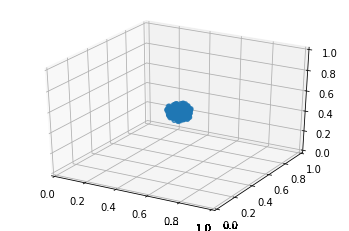

In [74]:
for i in range(max_iter):
    
    root = None
    for body in bodies:
        body.reset_to_0th_octant()
        root = add(body, root)
    
    verlet(bodies, root, theta, G, dt)
           
    if i%img_iter==0:
        print("Writing images at iteration {0}".format(i))
        plot_bodies(bodies, i//img_iter)
        firstbody = bodies[0]
        print(firstbody.m_pos[2])